# Step 1: Analyzing FERENGI Data 
## Determine correctable / uncorrectable regions of z/mu space. Ferengi galaxies that are considered 'correctable' are used to compute zeta in Step 2. This also generates low and hi limit values of p_features for the Hubble galaxies, which are useful particularly in cases where the values can't be confidentely debiased. 

In [1]:
%pylab inline
from astropy.io import fits
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table,Column
import os
import warnings
import requests

mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.linewidth'] = 3

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True);

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data from Dropbox folder instead of clogging up Github

def download_from_dropbox(url):
    
    local_filename = "../{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [3]:
#Load Data!
ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/r88l9u5fcsbppui/ferengi_all_weighted_and_meta.fits?dl=1")
data = Table.read(ferengi_filename) 

In [8]:
#Defining surface brightness bins
yedges=np.linspace(np.min(data['mu_max_i']),np.max(data['mu_max_i']),10)

In [9]:
p_x= 't00_smooth_or_features_a1_features_frac_weighted_2' 


In [10]:
#Pick out unique galaxies
galaxies = set(data['objid'])

In [11]:
#simulated redshifts of ferengi data:
reds=[.3,.4,.5,.6,.7,.8,.9,1]

#Defining lists of p_features at high and low (z=0.3) redshifts at given SB and redshifts. 
scatter_dct={}
for z in reds:
    for edge in yedges:
        scatter_dct[z,edge,'hi']=[]
        scatter_dct[z,edge,'lo']=[]
        scatter_dct[z,edge,'subj_id']=[]
        
for i,g in enumerate(galaxies):
    this_gal=(data['objid']==g)
    evos = set(data[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(data[this_gal]['sim_evolution']==e)
        if len(set(data[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(data[this_gal][this_evo]['sim_redshift']==.3)
            p_feat_at_3 = data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            for row in data[this_gal][this_evo]:
                for y in range(0,len(yedges)-1):
                    for j,hi_z in enumerate(reds):
                        if round(row['sim_redshift'],2)==hi_z and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1]: #now look at high redshift data 
                            scatter_dct[hi_z,yedges[y],'hi'].append(row[p_x]) # slap p_x in high list 
                            scatter_dct[hi_z,yedges[y],'lo'].append(p_feat_at_3) # put z=0.3 value in low list 
                             

In [8]:
def derivative_of_poly(x_list,fit_cos,deg):
    if deg == 3:
        derivative=3*fit_cos[3]*x_list**2+2*fit_cos[2]*x_list+fit_cos[1]
    if deg == 2:
        derivative=2*fit_cos[2]*x_list+fit_cos[1]
    if deg ==1:
        derivative=fit_cos[1]


    return derivative

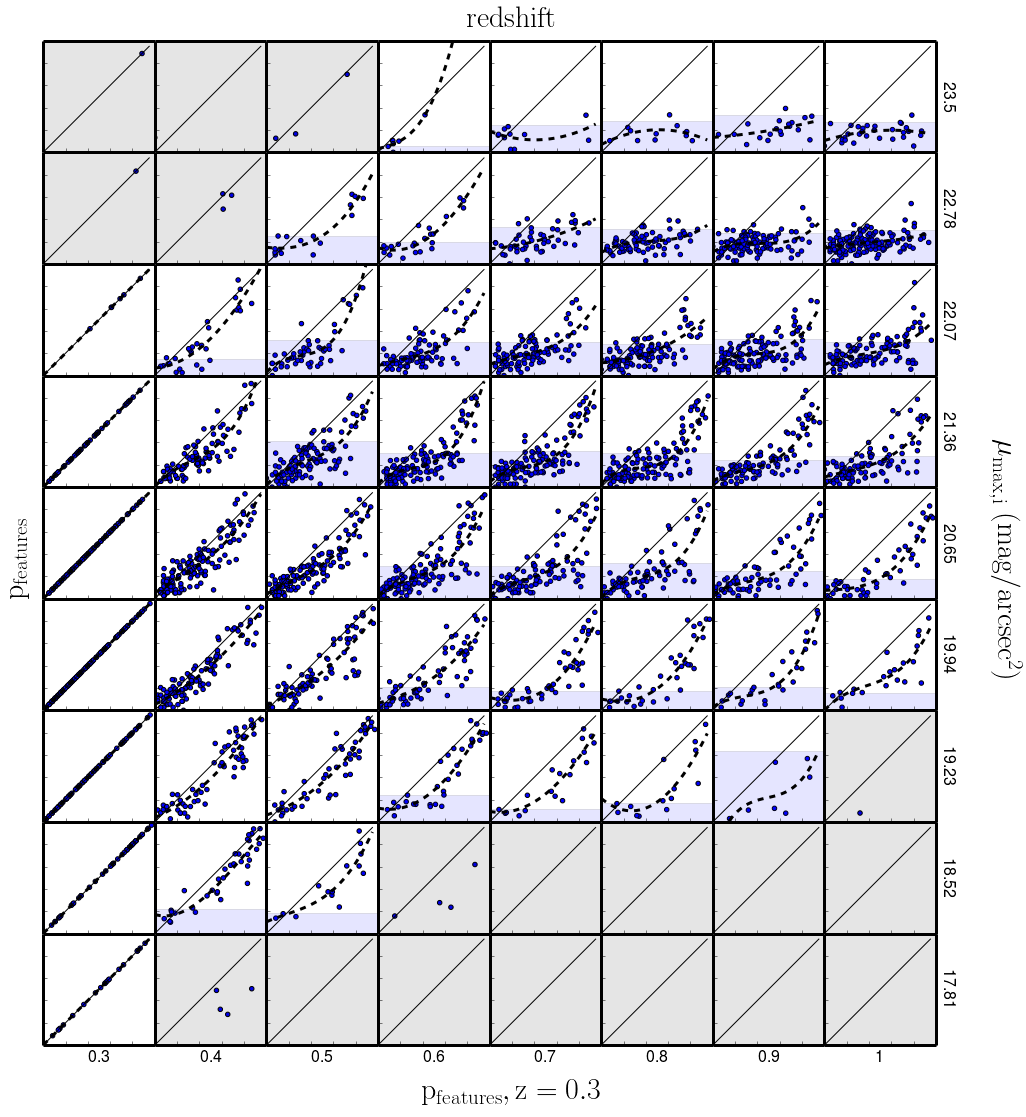

In [17]:
#Plot p_features at a given redshift vs p_features at z=0.3 at each redshift, binned by surface brightness
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.4

gs=gridspec.GridSpec(9,10)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=[8,7,6,5,4,3,2,1,0]
y_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
y_label=y_label[::-1]
for j,y in enumerate(yedge_int):
    for i,z in enumerate(reds):
        ax=plt.subplot(gs[j,i])
        xs=scatter_dct[z,yedges[y],'lo']
        ys=scatter_dct[z,yedges[y],'hi']
        plt.plot(x_new,x_new,c='k')
        flat_list=[]
        p_range_uncorrectable_dct[z,yedges[y]]=[]
        p_range_correctable_dct[z,yedges[y]]=[]
        plt.scatter(xs,ys)
        if len(xs)>5:
            poly_params=np.polynomial.polynomial.polyfit(xs,ys,3)
            poly = np.polynomial.Polynomial(poly_params)
            drv=derivative_of_poly(x_new,poly_params,3)
            if np.min(drv)>-.3: #fit okay, go ahead and plot
                plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='k',lw=3,ls='dashed')
                for d,val in enumerate(drv):
                    if val < slope_cut:
                        flat_list.append(x_new[d]) #list of x-values for shaded region
                if len(flat_list)>0: # if there are bad regions, record stuff:
                    min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                    max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                    #get list of y values in shaded region
                    bad_p_at_z_list=[] 
                    for p_int,p in enumerate(xs): 
                        if p>=min_p_at_3 and p < max_p_at_3:
                            bad_p_at_z_list.append(ys[p_int])
                    #shade out 3 standard deviations above and below the mean of that area        
                    min_val = 0 #I think the minimum should be 0...because... 
                    if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                        max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                    else:
                        max_val=0
                    plt.axhspan(0,max_val,alpha=.1)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                    p_range_correctable_dct[z,yedges[y]].append(max_val)
                    p_range_correctable_dct[z,yedges[y]].append(1)
                else: #if no bad regions, whole square is correctable.    
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                    p_range_correctable_dct[z,yedges[y]].append(0)
                    p_range_correctable_dct[z,yedges[y]].append(1)



            else: #if < 0, try 2nd order instead 
                poly_params=np.polynomial.polynomial.polyfit(xs,ys,2)
                poly = np.polynomial.Polynomial(poly_params)
                drv=derivative_of_poly(x_new,poly_params,2)
                if np.min(drv)>-1: #fit okay, go ahead and plot
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='k',lw=3,ls='dashed')
                    for d,val in enumerate(drv):
                        if val < slope_cut:
                            flat_list.append(x_new[d]) #list of x-values for shaded region
                    if len(flat_list)>0: # if there are bad regions, record stuff:
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=[] 
                        for p_int,p in enumerate(xs): 
                            if p>=min_p_at_3 and p < max_p_at_3:
                                bad_p_at_z_list.append(ys[p_int])
                        #shade out 3 standard deviations around the mean of that area        
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        plt.axhspan(min_val,max_val,alpha=.1)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                        p_range_correctable_dct[z,yedges[y]].append(max_val)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                    else: #if no bad regions, whole square is correctable.    
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                        p_range_correctable_dct[z,yedges[y]].append(0)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                else: #fit still bad, do a linear
                    poly_params=np.polynomial.polynomial.polyfit(xs,ys,1)
                    poly = np.polynomial.Polynomial(poly_params)
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='k',lw=3,ls='dashed')
                    drv=derivative_of_poly(x_new,poly_params,1)
                    if drv < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                        flat_list=x_new #list of x-values for shaded region
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=ys
                        min_val=0
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        plt.axhspan(min_val,max_val,alpha=.1)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                        p_range_correctable_dct[z,yedges[y]].append(max_val)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                    else: #if no bad regions, whole square is correctable.    
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                        p_range_correctable_dct[z,yedges[y]].append(0)
                        p_range_correctable_dct[z,yedges[y]].append(1)

        
            plt.xlim(0,1)
            plt.ylim(0,1)
   
        else: #fewer than 5 points in square, so fuck it
            plt.axhspan(0,1,alpha=.1,color='k')
            plt.xlim(0,1)
            plt.ylim(0,1)
            p_range_uncorrectable_dct[z,yedges[y]].append(0)
            p_range_uncorrectable_dct[z,yedges[y]].append(0) 
            p_range_correctable_dct[z,yedges[y]].append(0)
            p_range_correctable_dct[z,yedges[y]].append(0)
            
        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')

                
        if j==8:
            plt.xlabel('%s'%reds[i],fontsize=16)
        if i==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(y_label[j]).rjust(500),fontsize=16,rotation=270,labelpad=20)

f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{features}}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{features},z=0.3}$',fontsize=30,ha='center');

plt.savefig('/home/mel/Dropbox/gzhubble/Images/p_vs_p_SB_redshift_slope_method.pdf')
plt.savefig('../../writeup/figures/p_vs_p_SB_redshift.pdf')

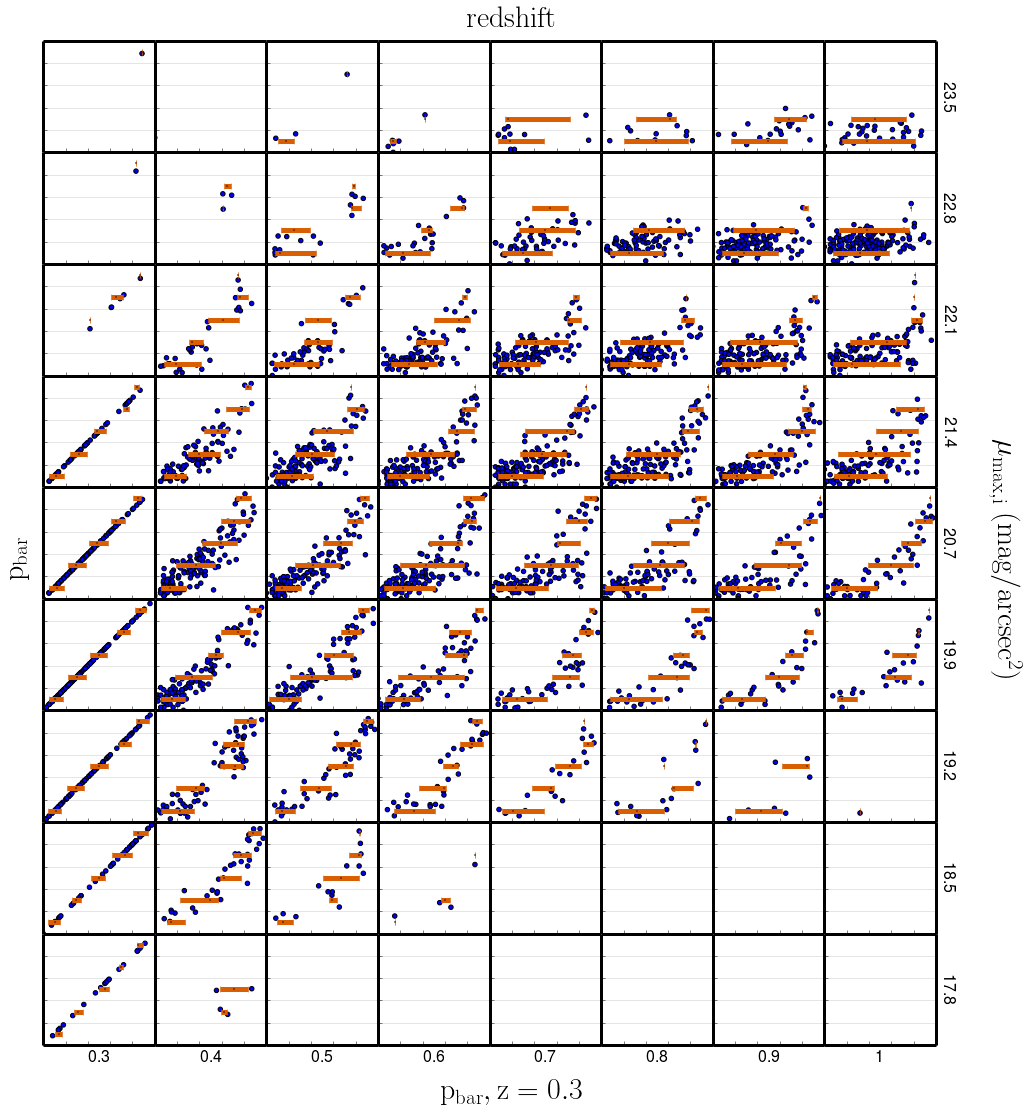

In [122]:
#Here we'll compute the scatter in the points for different bins of measured p_values, so we can provide upper limits
#on p_features for the difficult galaxies. 

f=figure(figsize=(20,18))
#store range of spread of data in each bin
interval_dct={}


gs=gridspec.GridSpec(9,10)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=[8,7,6,5,4,3,2,1,0]
y_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,1))
y_label=y_label[::-1]
for j,y in enumerate(yedge_int):
    for i,z in enumerate(reds):
        ax=plt.subplot(gs[j,i])
        xs=scatter_dct[z,yedges[y],'lo']
        ys=scatter_dct[z,yedges[y],'hi']
        plt.scatter(xs,ys)
        interval_dct[z,yedges[y]]=[]
        plt.xlim(0,1)
        plt.ylim(0,1)
        this_dct={}  #stores p_features at z=0.3 value for each bin (xs); use to compute spread in each bin
                    #stored like: this_dct[lower_bin_edge,higher_bin_edge] = [distribution of xs in bin]

        bins_list=np.linspace(0,1,6) #bin measured p_features from 0 to 1
        for b in range(0,len(bins_list)-1):
            bin_bottom = round(bins_list[b],1)
            bin_top = round(bins_list[b+1],1)
            this_dct[bin_bottom,bin_top]=[]
            for l,val in enumerate(ys): #check p_features at z values
                if val >= bin_bottom and val < bin_top: # if it falls inside bin in question:
                    this_dct[bin_bottom,bin_top].append(xs[l]) #then put corresponding p_features,z=0.3 value in list
        
        #Now compute the mean and spread of p_features,z=0.3 for each bin
        p_features_means=[]
        x_error_lo=[]
        x_error_hi=[]
        bin_centers=[]

        for b in range(0,len(bins_list)-1):
            bin_bottom = round(bins_list[b],3)
            bin_top = round(bins_list[b+1],3)
            plt.axhline(bin_bottom,c='k',lw=1,alpha=.1)
            p_features_means.append(np.median(this_dct[bin_bottom,bin_top]))
            try:
            #    x_error_lo.append(p_features_means[b] - np.percentile(this_dct[bin_bottom,bin_top],10))
                x_error_lo.append(np.percentile(this_dct[bin_bottom,bin_top],50) - np.percentile(this_dct[bin_bottom,bin_top],10))

            except IndexError:
                x_error_lo.append(0)
            try:
              #  x_error_hi.append(np.percentile(this_dct[bin_bottom,bin_top],90) - p_features_means[b])
                x_error_hi.append(np.percentile(this_dct[bin_bottom,bin_top],90) - np.percentile(this_dct[bin_bottom,bin_top],50))
                
            except IndexError:
                x_error_hi.append(0)
            bin_centers.append((bin_top-bin_bottom)/2.+bin_bottom)
            try:
                interval_dct[z,yedges[y]].append({'bin_bottom':bin_bottom,'bin_top':bin_top,'low_limit':np.percentile(this_dct[bin_bottom,bin_top],10),'hi_limit':np.percentile(this_dct[bin_bottom,bin_top],90)})
            except IndexError:
                pass
        plt.errorbar(p_features_means,bin_centers,xerr=[x_error_lo,x_error_hi],fmt='o',c='#d95f02',markersize=1,elinewidth=5)

        

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')

        if j==8:
            plt.xlabel('%s'%reds[i],fontsize=16)
        if i==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%y_label[j],fontsize=16,rotation=270,labelpad=20)

f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{bar}}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{bar},z=0.3}$',fontsize=30,ha='center')

plt.savefig('/home/mel/Dropbox/gzhubble/Images/low_hi_bins.pdf')

In [46]:
#get list of debiasable ferengi galaxies 
unique_galaxies = set(data['objid'])
z0ind = np.zeros(len(data),dtype=bool)
for ug in unique_galaxies:
    ind = (data['objid'] == ug)
    if data[ind]['sim_redshift'].min() < 0.301:
        z0ind[ind] = True
        
data_z0 = data[z0ind]
category_list_ferengi=[]
for row in data_z0:
    if row['mu_max_i'] > yedges[0] and row['mu_max_i'] <= yedges[len(yedges)-1] and  row['sim_redshift'] > reds[0]-.05 and row['sim_redshift'] <= reds[len(reds)-1] + .05: # if within ferengi space, check where it is. else, consider NEI or uncorrectable.
        for y in range(0,len(yedges)-1):
            if row['mu_max_i'] > yedges[y] and row['mu_max_i'] <= yedges[y+1]:  
                for i,z in enumerate(reds): 
                    if row['sim_redshift'] > reds[i]-.05 and row['sim_redshift'] <= reds[i] + .05: # pick out where it is in SB/z and check color
                        if row[p_x] > p_range_correctable_dct[z,yedges[y]][0] and row[p_x] <= p_range_correctable_dct[z,yedges[y]][1]:# if it's in correctable range::
                            category_list_ferengi.append({'sdss_id':row['objid'],'subject_id':row['subject_id_1'],'Correctable_Category':'correctable','sim_redshift':row['sim_redshift'],'p_features':row[p_x],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})
                        elif row[p_x] > p_range_uncorrectable_dct[z,yedges[y]][0] and row[p_x] <= p_range_uncorrectable_dct[z,yedges[y]][1]:# if it's in uncorrectable range::
                            category_list_ferengi.append({'sdss_id':row['objid'],'subject_id':row['subject_id_1'],'Correctable_Category':'uncorrectable','sim_redshift':row['sim_redshift'],'p_features':row[p_x],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})
                        else: #not in correctable or uncorrectable range, so nei
                            category_list_ferengi.append({'sdss_id':row['objid'],'subject_id':row['subject_id_1'],'Correctable_Category':'nei','sim_redshift':row['sim_redshift'],'p_features':row[p_x],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})
    else: #galaxies outside ferengi SB and z limits - still need to have meaasureable z and SB to possibly correct. 
        if row['sim_redshift'] > 0 and row['sim_redshift'] < 9 and row['mu_max_i'] >0: #these have measurements for z and SB, put in NEI
                            category_list_ferengi.append({'sdss_id':row['objid'],'subject_id':row['subject_id_1'],'Correctable_Category':'nei','sim_redshift':row['sim_redshift'],'p_features':row[p_x],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})
        else: #these have nan or infinite values of z or mu, put in need_redshift_list
                            category_list_ferengi.append({'sdss_id':row['objid'],'subject_id':row['subject_id_1'],'Correctable_Category':'nei_needs_redshift','sim_redshift':row['sim_redshift'],'p_features':row[p_x],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})


# Output time
## write file categorizing Ferengi galaxies. This will be used in Step 2 to compute zeta using the correctable galaxies, and in Step 3 the corretable/uncorrectable regions will be smoothed out to apply to the Hubble data.

In [48]:
#create fits file of galaxies with Correctable_Category Label for FERENGI
c0 = Column([x['sdss_id'] for x in category_list_ferengi], name='sdss_id', format='A24') 
c00 = Column([x['subject_id'] for x in category_list_ferengi], name='subject_id', format='A24') 
c01 = Column([x['Correctable_Category'] for x in category_list_ferengi], name='Correctable_Category',format='A24')
c02 = Column([x['p_features'] for x in category_list_ferengi], name='p_features',format='D')
c03 = Column([x['sim_redshift'] for x in category_list_ferengi], name='sim_redshift',format='D')
c04 = Column([x['sim_evolution'] for x in category_list_ferengi], name='sim_evolution',format='D')
c05 = Column([x['mu_max_i'] for x in category_list_ferengi], name='mu_max_i',format='D')

category_table_ferengi = Table()  
category_table_ferengi.add_columns([c0,c00,c01,c02,c03,c04,c05])

fname = '/home/mel/Dropbox/gzhubble/ferengi_files/ferengi_data_with_categories_slope_method.fits'
if os.path.exists(fname):
    os.remove(fname)
category_table_ferengi.write(fname,format='fits')

In [49]:
print 'The number of correctable ferengi galaxies is %i' %((category_table_ferengi['Correctable_Category'] == 'correctable')).sum()
print 'The number of uncorrectable ferengi galaxies is %i' %((category_table_ferengi['Correctable_Category'] == 'uncorrectable')).sum()
print 'The number of nei galaxies is %i' %((category_table_ferengi['Correctable_Category'] == 'nei')).sum()
print 'Total: %i' %len(category_table_ferengi)

The number of correctable ferengi galaxies is 1884
The number of uncorrectable ferengi galaxies is 1986
The number of nei galaxies is 80
Total: 3950


# Input time
## Now definte the low and high limits of p_features for all of the Hubble galaxies, depending on where they exist in z/mu space. 

In [50]:
hubble_filename = download_from_dropbox("https://www.dropbox.com/s/0ajr9pnx2odhlw6/gzh_t01_z_mu.fits?dl=1")
hubble_data = Table.read(hubble_filename) 


/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [123]:
low_hi_limit_list=[]
p_features='t01_smooth_or_features_a02_features_or_disk_weighted_fraction'
Z='Z_BEST'
for row in hubble_data:
    if row['MU_HI'] > yedges[0] and row['MU_HI'] <= yedges[len(yedges)-1] and  row[Z] > reds[0]-.05 and row[Z] <= reds[len(reds)-1] + .05: 
        for y in range(0,len(yedges)-1):
            if row['MU_HI'] > yedges[y] and row['MU_HI'] <= yedges[y+1]:  
                for i,red in enumerate(reds): 
                    if row[Z] > reds[i]-.05 and row[Z] <= reds[i] + .05: #now we have mu,z info:
                        for bin_range in interval_dct[red,yedges[y]]:
                            if row[p_features] >= bin_range['bin_bottom'] and row[p_features] < bin_range['bin_top']:
                                low_hi_limit_list.append({'OBJNO':row['OBJNO'],'Z_BEST':row[Z],'MU_HI':row['MU_HI'],'low_limit':bin_range['low_limit'],'hi_limit':bin_range['hi_limit'],'p_features_weighted':row[p_features]})

In [125]:
#create fits file of lower and upper limits for p_features
c1 = Column([x['OBJNO'] for x in low_hi_limit_list], name='OBJNO') 
c2 = Column([x['Z_BEST'] for x in low_hi_limit_list], name='Z_BEST')
c3 = Column([x['MU_HI'] for x in low_hi_limit_list], name='MU_HI')
c4 = Column([x['p_features_weighted'] for x in low_hi_limit_list], name='t01_smooth_or_features_a02_features_or_disk_weighted_fraction')
c5 = Column([x['low_limit'] for x in low_hi_limit_list], name='t01_smooth_or_features_a02_features_or_disk_lower_limit') 
c6 = Column([x['hi_limit'] for x in low_hi_limit_list], name='t01_smooth_or_features_a02_features_or_disk_upper_limit') 
limit_table = Table()  
limit_table.add_columns([c1,c2,c3,c4,c5,c6])

fname = '/home/mel/Dropbox/gzhubble/hubble_files/lo_hi_limits.fits'
if os.path.exists(fname):
    os.remove(fname)
limit_table.write(fname,format='fits')